## Kirchoff modeling with Madagascar package

The following script builds a gaussian reflector velocity model where velocity increases linearly with depth by a 0.5
velocity gradient. The near surface velocity is 1.5Km/s

In [1]:
from m8r import view

To build a gaussian reflector in madagascar someone could use _sfmath_ 
to draw the reflector interface using the gaussian
equation above:

$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}
$$

In [2]:
%%file 1_gaussianReflectorVelocityModel.scons 

#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# SConstruct  (Madagascar Script)
#
# Purpose: Model a data cube A(m,h,t) using Kirchoff modeling.
#
# Site: http://www.dirackslounge.online
# 
# Version 1.0
#
# Programer: Rodolfo A. C. Neves (Dirack) 18/09/2019
#
# Email: rodolfo_profissional@hotmail.com
#
# License: GPL-3.0 <https://www.gnu.org/licenses/gpl-3.0.txt>.


# Madagascar library

# Python math library
import math

# Ploting functions
from graph_scons import *

# Modeling: Gaussian reflector in a velocity linear model
# velocity increases with depth with a 0.5 velocity gradient
Flow('gaussianReflector',None,
     '''
     math d1=0.01 n1=2001 o1=-5 unit1=km label1=Offset
     output="4-3*exp(-(x1-5)^2/9)"
     ''')

Writing 1_gaussianReflectorVelocityModel.scons


The interface is the concatenation of the figure frame with the drawned interface, because of that we use this
loop and plot to concatenate both figures.

In [3]:
%%file 2_frame.scons

for g in range(2):
    gaussianReflector = 'gaussianReflector%d' % g
    Plot(gaussianReflector,'gaussianReflector',
         '''
         graph min2=0 max2=4 min1=0 max1=10
         yreverse=y plotcol=%d plotfat=%d
         wantaxis=n wanttitle=n scalebar=y pad=n
         ''' % ((7,0)[g],(7,3)[g]))

Result('frame','gaussianReflector0 gaussianReflector1','Overlay')

Writing 2_frame.scons


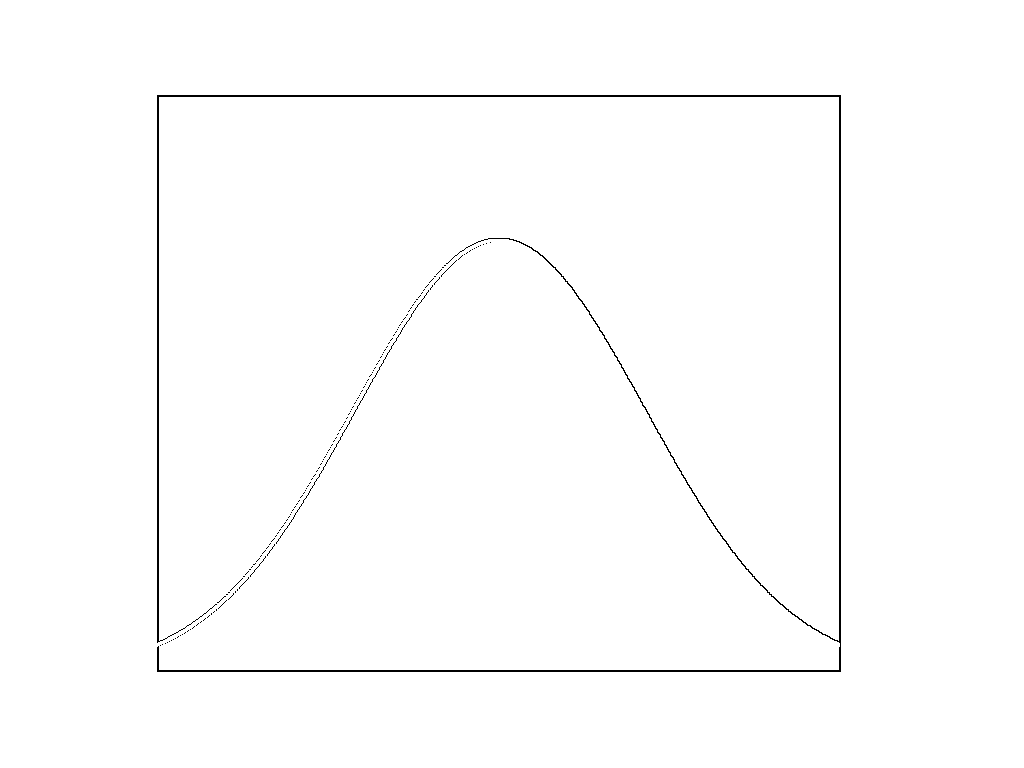

In [7]:
view('frame')

The velocity model is drawn using a line equation in _sfmath_ and spraying it along the first axis with _sfspray_.
We use _sfmath_
to draw the background velocity model, because the kirchoff modeling program _sfkirmod_ acepts only this types of 
velocity models:

 * 'c': constant
 * 's': linear sloth
 * 'v': linear velocity (default)
 * 'a': VTI anisotropy

In [4]:
%%file 3_velocityModel.scons
# Velocity Model
Flow('velocityModel','gaussianReflector',
     '''
     window min1=0 max1=10 |
     spray axis=1 n=451 d=0.01 o=0 label=Depth unit=km |
     math output="1.5+0.5*x1+0.0*x2"
     ''')

Plot('velocityModel',
     '''
     grey color=j allpos=y bias=1.5 scalebar=y wanttitle=n
     barreverse=y barlabel=Velocity barunit=km/s
     ''')

Result('bgVelocityModel','velocityModel',
       '''
       grey color=j wanttitle=n bias=1.5 allpos=y scalebar=y
       barreverse=y barlabel=Velocity barunit=Km/s
       ''')

Writing 3_velocityModel.scons


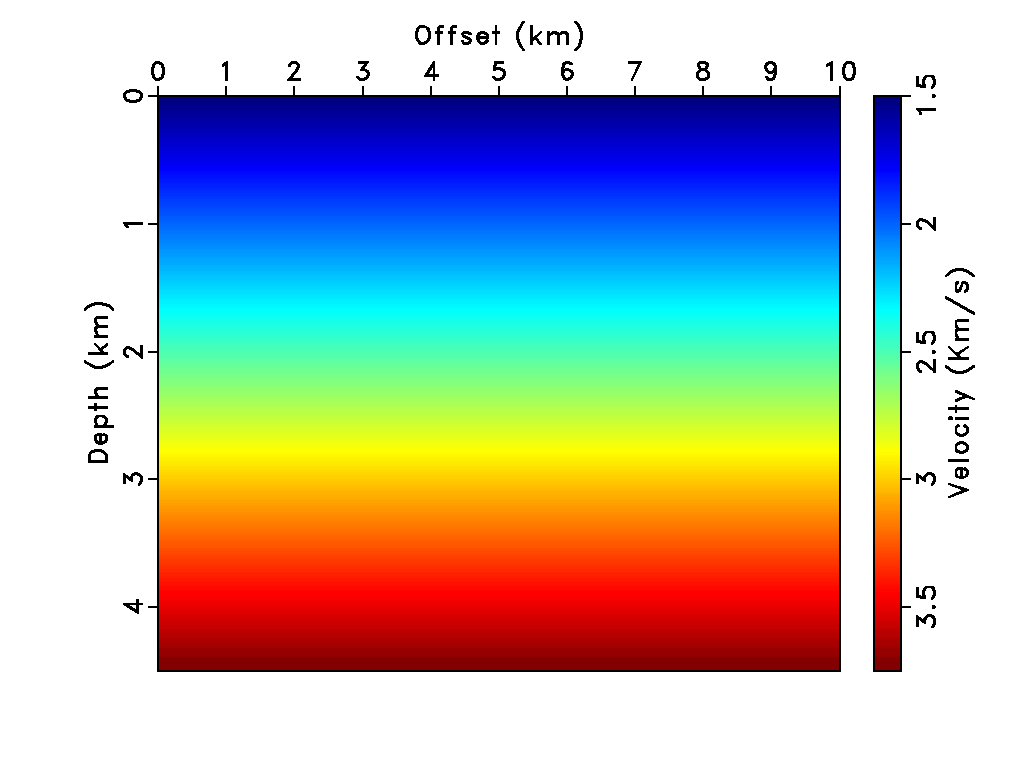

In [11]:
view('bgVelocityModel')

Concatenate gaussian interface and background velocity model to obtain the full velocity model:

In [5]:
%%file 4_fullModel.scons

Result('gaussianReflectorVelocityModel','velocityModel gaussianReflector0 gaussianReflector1','Overlay')

Writing 4_fullModel.scons


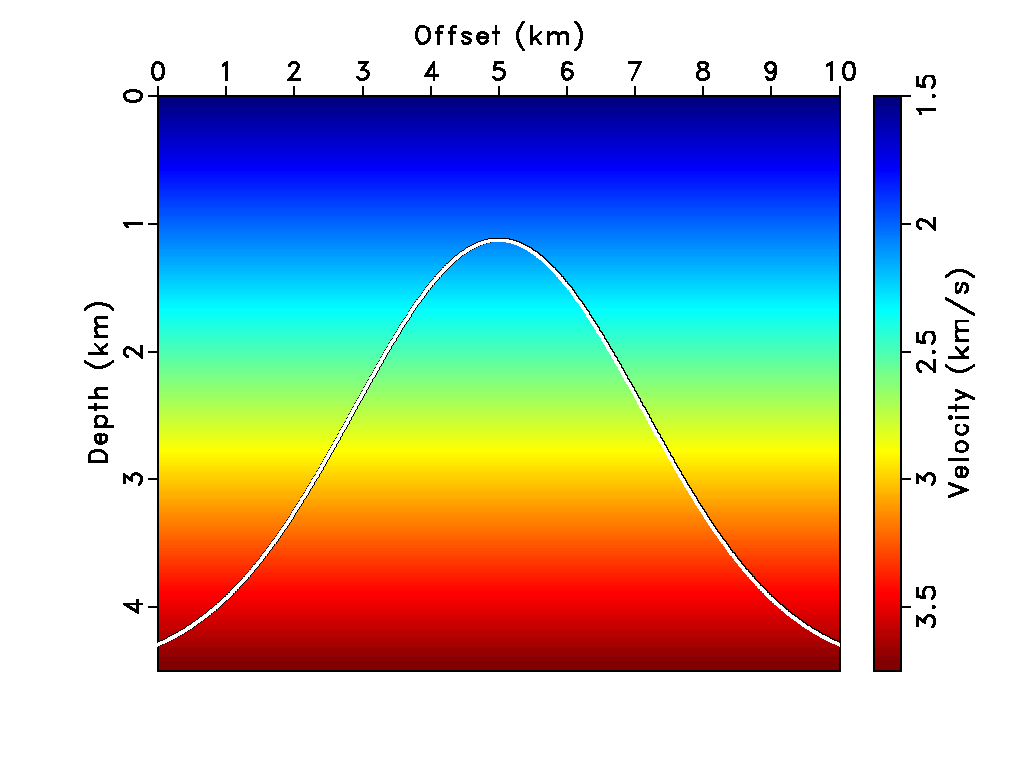

In [13]:
view("gaussianReflectorVelocityModel")

### Build data cube

A _seismic data cube_ is the seismic modeled data from the previous step organized by CMP coordinates m, half-offset h
and time t. So, every sample A(m,h,t) in the data space can be identified by a triple m,h,t.

The program _sfkirmod_ needs the reflector coordinates and dip, the dip can be obtained with _sfderiv_, 
or just calculating the derivative of the gaussian reflector's as in the first Flow above.

You can choose if the data is organized by CMP or shot coordinates in the key **cmp=y/n** (y for CMP).
And You've got to specify the number of receivers/half-offsets **nh**, receivers/half-offsets **dh**, 
and sample and it's origin **h0**.
The number of sources/CMP's **ns**, sources/CMP sampling **ds**, and it's origin **s0**.
The peak frequency of the wavelet Ricker pulse **freq**,
time data sample **dt** and number of samples **nt** should be choosen too.

The **vel** parameter describes the near surface velocity and it's gradient in z and x 
is described by **gradz** and **gradx** parameters.

In [6]:
%%file 5_dataCube.scons 


Flow('reflectorDip','gaussianReflector','math output="2/3*(x1-5)*input" ')

# Kirchoff Modeling
Flow('dataCube','gaussianReflector reflectorDip',
     '''
     kirmod cmp=y dip=${SOURCES[1]} 
     nh=161 dh=0.025 h0=0
     ns=401 ds=0.025 s0=0
     freq=10 dt=0.004 nt=1001
     vel=1.5 gradz=0.5 gradx=0.0 verb=y |
     put d2=0.0125 label3="CMP" unit3="Km" label2="Offset" unit2="Km" label1=Time unit1=s
     ''')

Result('dataCube',grey3('Modeled seismic data cube'))

Writing 5_dataCube.scons


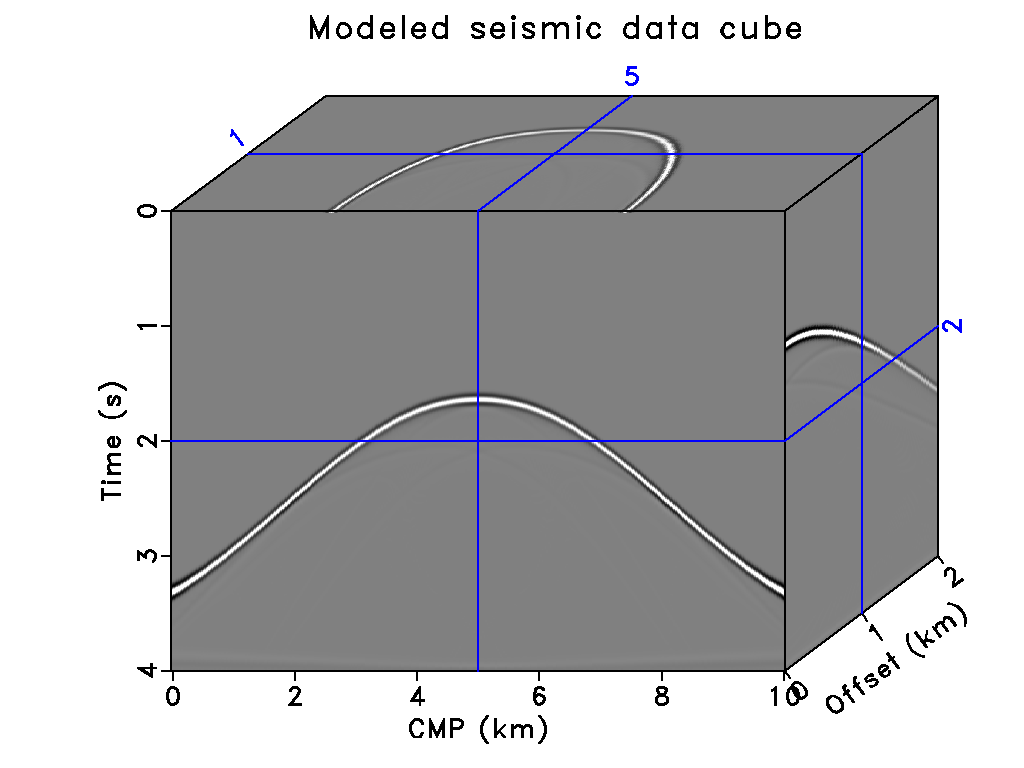

In [6]:
view("dataCube")

### Extract a CMP gather from seismic data cube

Someone can extract the 5Km CMP gather from seismic data cube using _sfwindow_. 
Selecting one sample in CMP (n3=1) with the 
index f3=200 (because d3 x f3 + o3 = 0.025 x 200 + 0 = 5).

To check the data sample use _sfin_ command:

In [7]:
!sfin < dataCube.rsf

in:
    in="/var/tmp/experiments/modeling/scons/dataCube.rsf@"
    esize=4 type=float form=native 
    n1=1001        d1=0.004       o1=0          label1="Time" unit1="s" 
    n2=161         d2=0.0125      o2=0          label2="Offset" unit2="Km" 
    n3=401         d3=0.025       o3=0          label3="CMP" unit3="Km" 
	64625561 elements 258502244 bytes


So, cut a CMP gather with _sfwindow_:

In [7]:
%%file 6_cmpGather.scons 


# Select a CMP gather m0=5Km
Flow('cmpGather','dataCube',
	'''
	window n3=1 f3=200
	''')

Result('cmpGather',grey('CMP Gather 5Km'))

Writing 6_cmpGather.scons


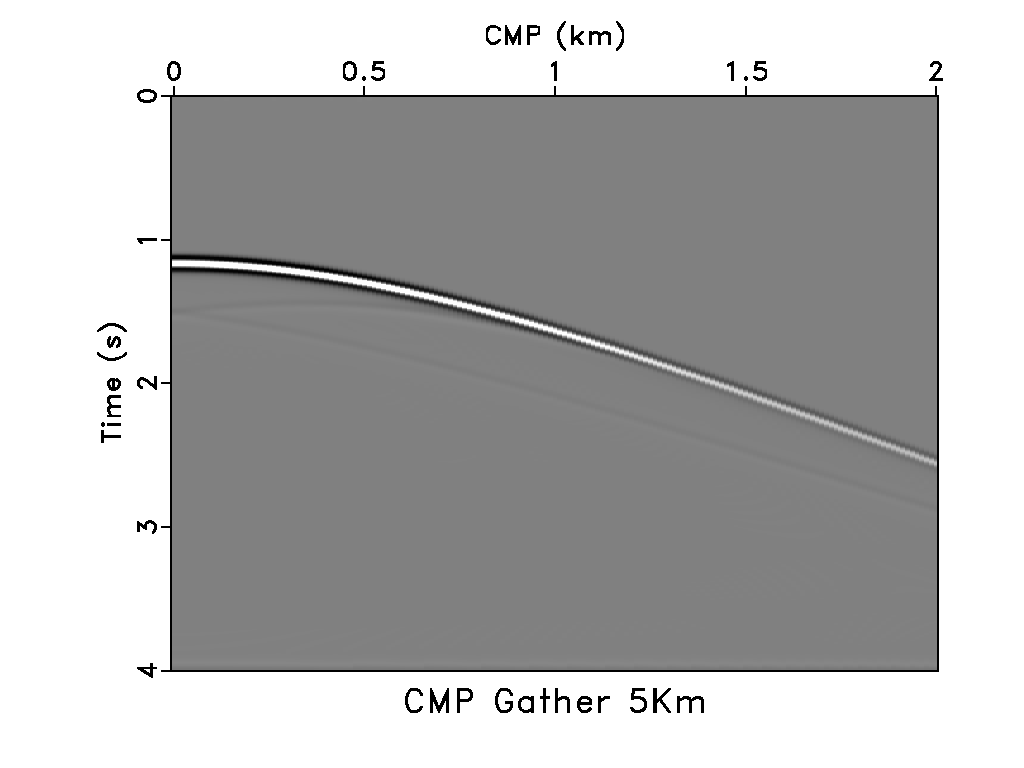

In [9]:
view("cmpGather")